In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

base_folder = r"D:\TRAINING MODEL"
out_folder  = os.path.join(base_folder, "data", "processed")
df = pd.read_csv(os.path.join(out_folder, "master_dataset_cleaned.csv"))

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows where Total is NaN (since it's the target)
df = df.dropna(subset=["Total"])

# Optionally, fill NaNs in features with 0 or mean
df = df.fillna(0)

print(df.head())

# Features (X) and Target (y)
X = df.drop("Total", axis=1)
y = df["Total"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)

# Comparison DataFrame
comparison = pd.DataFrame({
    "Actual": y_test.reset_index(drop=True),
    "Predicted": y_pred
})
print(comparison.head(20))


--- Data Loaded Successfully ---
Shape of the dataset: (20032, 7)

--- Case Dictionary Loaded Successfully ---

--- Annual Totals per Consultation Type ---
   Year Consultation_Type_Name  Total
0  2023           Consultation  14682
1  2023              Diagnosis   6811
2  2023              Mortality    176
3  2024           Consultation  19825
4  2024              Diagnosis  14578
5  2024              Mortality    273


--- Holiday Correlation Analysis (Outbreak Flag) ---
Average total cases on major holiday months (Jan, Nov, Dec): 2973.60
Average total cases on non-holiday months: 2592.31


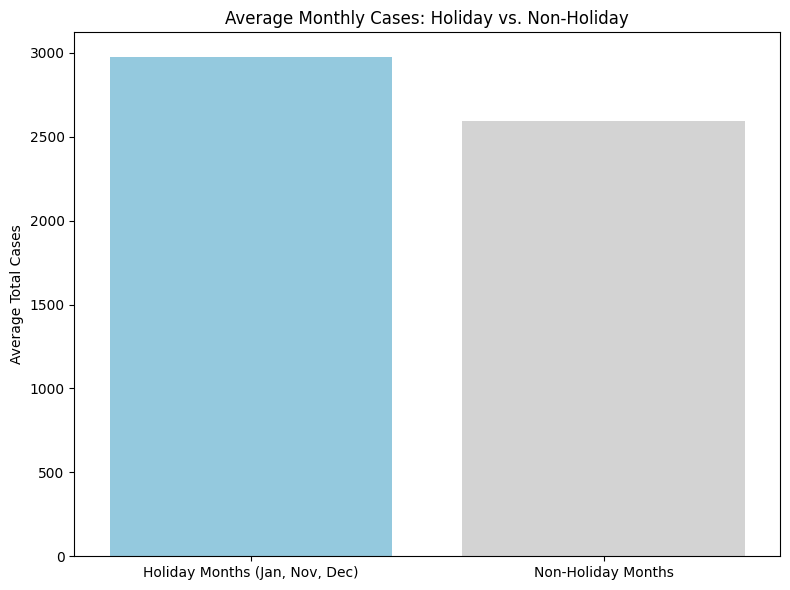

--- Building and Evaluating Random Forest Model ---
Training data shape: (16025, 7)
Testing data shape: (4007, 7)
Model training complete.

--- Model Evaluation (on 20% Random Test Set) ---
Mean Absolute Error (MAE): 1.3649
Mean Squared Error (MSE): 11.2323
R-squared (R²): 0.8320

--- Predicting Top Cases for Next Month ---
Data last recorded in: 2024-12
Predicting for: 2025-01

--- Top 5 Predicted Cases for Next Month ---
    Consultation_Type_Name                                          Case_Name  \
82            Consultation                                                OPD   
0             Consultation                                              FEVER   
1             Consultation                                       FOR RAT ONLY   
2             Consultation                                           VOMITING   
5             Consultation                                              COUGH   
271              Diagnosis                                                OPD   
268   

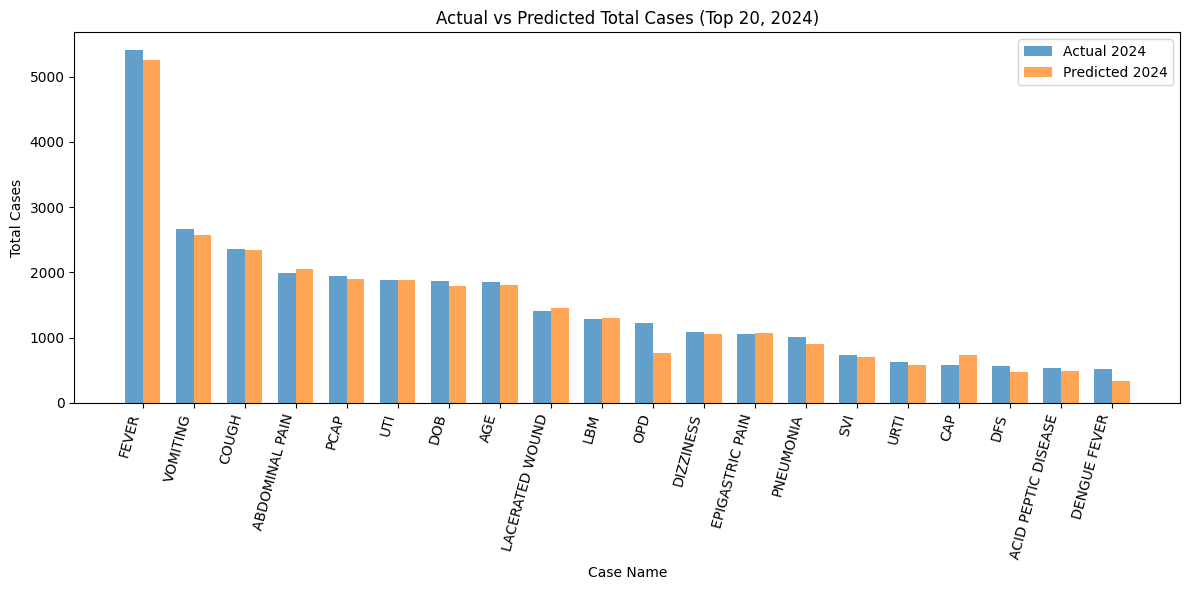

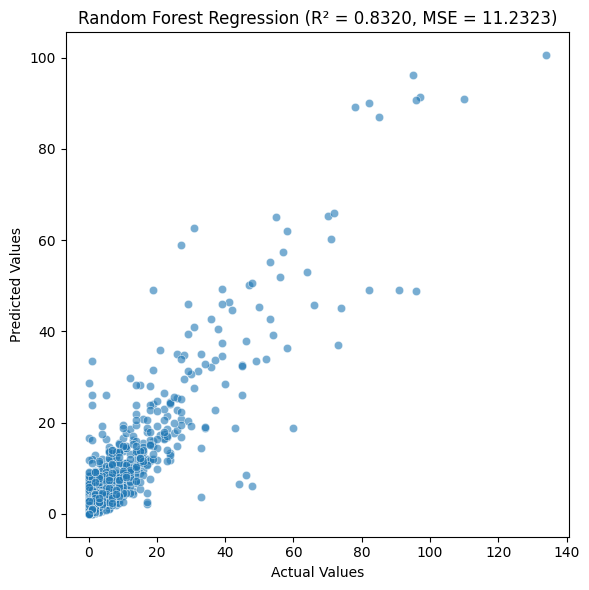

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import itertools
import warnings
import json

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Mappings for Readability ---
consultation_map = {1: "Consultation", 2: "Diagnosis", 3: "Mortality"}

# --- 1. Load Data and Case Mappings ---
try:
    df = pd.read_csv('master_dataset_cleaned.csv')
    print("--- Data Loaded Successfully ---")
    print(f"Shape of the dataset: {df.shape}\n")
except FileNotFoundError:
    print("Error: 'master_dataset_cleaned.csv' not found. Please ensure the file is in the correct directory.")
    exit()

try:
    with open('case_dictionary.json', 'r') as f:
        # Load JSON. The file has names as keys and IDs as values.
        case_map_str_keys = json.load(f)
        # We need to invert the dictionary so IDs are keys and names are values.
        case_map = {v: k for k, v in case_map_str_keys.items()}
    print("--- Case Dictionary Loaded Successfully ---\n")
except FileNotFoundError:
    print("Error: 'case_dictionary.json' not found. Please ensure the file is in the correct directory.")
    # Fallback to an empty dictionary if file not found
    case_map = {}


# --- 2. Data Analysis & Feature Engineering ---

# GOAL: Get total of each consultation_type per year
print("--- Annual Totals per Consultation Type ---")
annual_totals = df.groupby(['Year', 'Consultation_Type'])['Total'].sum().reset_index()
annual_totals['Consultation_Type_Name'] = annual_totals['Consultation_Type'].map(consultation_map)
print(annual_totals[['Year', 'Consultation_Type_Name', 'Total']])
print("\n")

# GOAL: Create outbreak flags for holidays
print("--- Holiday Correlation Analysis (Outbreak Flag) ---")
holiday_months = [1, 11, 12] # Jan (New Year), Nov (Undas), Dec (Christmas)
df['is_major_holiday'] = df['Month'].isin(holiday_months).astype(int)

monthly_totals = df.groupby(['Year', 'Month'])['Total'].sum().reset_index()
monthly_totals['is_major_holiday'] = monthly_totals['Month'].isin(holiday_months).astype(int)

holiday_avg = monthly_totals[monthly_totals['is_major_holiday'] == 1]['Total'].mean()
non_holiday_avg = monthly_totals[monthly_totals['is_major_holiday'] == 0]['Total'].mean()

print(f"Average total cases on major holiday months (Jan, Nov, Dec): {holiday_avg:.2f}")
print(f"Average total cases on non-holiday months: {non_holiday_avg:.2f}")

# Plot the correlation/comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=['Holiday Months (Jan, Nov, Dec)', 'Non-Holiday Months'], y=[holiday_avg, non_holiday_avg], palette=['skyblue', 'lightgrey'])
plt.title('Average Monthly Cases: Holiday vs. Non-Holiday')
plt.ylabel('Average Total Cases')
plt.tight_layout()
plt.show()
# plt.savefig('holiday_correlation_chart.png')
# print("Generated 'holiday_correlation_chart.png' plot.\n")

# --- 3. Model Training and Evaluation (Using Your Script's Method) ---
print("--- Building and Evaluating Random Forest Model ---")
# Features (X) and Target (y)
X = df.drop("Total", axis=1)
y = df["Total"]

# Split dataset using a random split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Create and train model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
model.fit(X_train, y_train)
print("Model training complete.")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0 # Ensure predictions are non-negative

# GOAL: Use R^2 and MAE for testing
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation (on 20% Random Test Set) ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}\n")

# --- 4. Monthly Prediction of Top Cases ---
print("--- Predicting Top Cases for Next Month ---")
# Find last date in the dataset
last_year = df['Year'].max()
last_month = df[df['Year'] == last_year]['Month'].max()

# Calculate the next month
if last_month == 12:
    next_month = 1
    next_year = last_year + 1
else:
    next_month = last_month + 1
    next_year = last_year

print(f"Data last recorded in: {last_year}-{last_month:02d}")
print(f"Predicting for: {next_year}-{next_month:02d}")

# Create a future prediction grid
all_cases = df['Case'].unique()
all_consult_types = df['Consultation_Type'].unique()
all_sexes = df['Sex'].unique()
all_age_ranges = df['Age_range'].unique()

future_combinations = list(itertools.product(all_consult_types, all_cases, all_sexes, all_age_ranges))
X_future = pd.DataFrame(future_combinations, columns=['Consultation_Type', 'Case', 'Sex', 'Age_range'])

# Add other necessary features for prediction
X_future['Year'] = next_year
X_future['Month'] = next_month
X_future['is_major_holiday'] = 1 if next_month in holiday_months else 0
X_future = X_future[X_train.columns] # Ensure column order matches training data

# Make predictions
future_predictions = model.predict(X_future)
future_predictions[future_predictions < 0] = 0
X_future['Predicted_Total'] = future_predictions

# Aggregate to find top cases
future_case_totals = X_future.groupby(['Consultation_Type', 'Case'])['Predicted_Total'].sum().reset_index()
future_case_totals['Predicted_Total'] = future_case_totals['Predicted_Total'].round(0).astype(int)

# Get top 5 for each consultation type
top_5_predictions = future_case_totals.sort_values('Predicted_Total', ascending=False).groupby('Consultation_Type').head(5)

# Map names for readability
top_5_predictions['Consultation_Type_Name'] = top_5_predictions['Consultation_Type'].map(consultation_map)
top_5_predictions['Case_Name'] = top_5_predictions['Case'].map(case_map).fillna(top_5_predictions['Case'].apply(lambda x: f'Case {x} (No Name)'))

print("\n--- Top 5 Predicted Cases for Next Month ---")
print(top_5_predictions.sort_values(by=['Consultation_Type_Name', 'Predicted_Total'], ascending=[True, False])[['Consultation_Type_Name', 'Case_Name', 'Predicted_Total']])

# --- 5. 2024 Actual vs. Predicted Comparison ---
print("\n--- Comparing Actual vs. Predicted Top 20 Cases for 2024 ---")

# Isolate all data from 2024
df_2024 = df[df['Year'] == 2024].copy()

# Define features and actual totals for 2024
X_2024 = df_2024.drop('Total', axis=1)
y_2024_actual = df_2024['Total']

# Use the trained model to predict on 2024 data
y_2024_pred = model.predict(X_2024)
y_2024_pred[y_2024_pred < 0] = 0

# Create a new DataFrame for comparison
comparison_2024_df = X_2024.copy()
comparison_2024_df['Actual_Total'] = y_2024_actual
comparison_2024_df['Predicted_Total'] = y_2024_pred.round(0).astype(int)

# Aggregate totals by case for a clearer view
actual_2024_totals = comparison_2024_df.groupby('Case')['Actual_Total'].sum()
predicted_2024_totals = comparison_2024_df.groupby('Case')['Predicted_Total'].sum()

# Get the top 20 actual cases
top_20_actual_cases = actual_2024_totals.nlargest(20).index

# Combine the results for the top 20 cases
comparison_summary = pd.DataFrame({
    'Actual_Total': actual_2024_totals[top_20_actual_cases],
    'Predicted_Total': predicted_2024_totals[top_20_actual_cases]
}).reset_index()

# Map case names for readability
comparison_summary['Case_Name'] = comparison_summary['Case'].map(case_map)

print(comparison_summary[['Case_Name', 'Actual_Total', 'Predicted_Total']])
# --- Visualization: Actual vs Predicted Totals for 2024 ---
plt.figure(figsize=(12, 6))
comparison_summary_sorted = comparison_summary.sort_values(by="Actual_Total", ascending=False)

# Plot bars for Actual vs Predicted
bar_width = 0.35
indices = np.arange(len(comparison_summary_sorted))

plt.bar(indices, comparison_summary_sorted['Actual_Total'], bar_width, label='Actual 2024', alpha=0.7)
plt.bar(indices + bar_width, comparison_summary_sorted['Predicted_Total'], bar_width, label='Predicted 2024', alpha=0.7)

plt.xticks(indices + bar_width / 2, comparison_summary_sorted['Case_Name'], rotation=75, ha='right')
plt.xlabel('Case Name')
plt.ylabel('Total Cases')
plt.title('Actual vs Predicted Total Cases (Top 20, 2024)')
plt.legend()
plt.tight_layout()

# plt.savefig('actual_vs_predicted_2024.png')
# plt.show()
plt.show

print("\nGenerated 'actual_vs_predicted_2024.png' showing Actual vs Predicted totals for 2024.")


# Predict on the test set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0  # Ensure predictions are non-negative

# --- Model Evaluation ---
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation (on 20% Random Test Set) ---")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Optional: Show a quick visual comparison
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Random Forest Regression (R² = {r2:.4f}, MSE = {mse:.4f})")
plt.tight_layout()
plt.show()
# plt.savefig('model_performance_scatter.png')
# print("Generated 'model_performance_scatter.png' showing actual vs predicted values.\n")
import joblib

# --- 6. Save the Trained Model ---
# model_filename = 'random_forest_model.pkl'
# joblib.dump(model, model_filename)

# print(f"\n✅ Model saved successfully as '{model_filename}'.")


In [ ]:
# train_model.py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# --- 1. Load Dataset ---
print("--- Loading dataset ---")
df = pd.read_csv('master_dataset_cleaned.csv')
print(f"Dataset shape: {df.shape}")

# --- 2. Feature / Target Split ---
X = df.drop("Total", axis=1)
y = df["Total"]

# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 4. Model Training ---
print("--- Training Random Forest Regressor ---")
model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1, 
    min_samples_leaf=5
)
model.fit(X_train, y_train)

# --- 5. Evaluate Model ---
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# # --- 6. Save Model ---
# model_filename = "random_forest_model.pkl"
# joblib.dump(model, model_filename)
# print(f"\n✅ Model saved as '{model_filename}'")


--- Loading dataset ---
Dataset shape: (20032, 7)
--- Training Random Forest Regressor ---

--- Model Evaluation ---
Mean Absolute Error: 1.3656
Mean Squared Error: 11.2414
R² Score: 0.8318
